# General Assembly Capstone: Time Series Forecasting of Texas Electricity Data
----


## <span style="color:Green">03 - Multivariate Time Series Model of Natural Gas Generation with Temperature Data</span>      
----

#### The below notebook conducts univariate time series analysis on the ERCOT natural gas data from 2013-20217. The dataset contains daily values of natural gas generation and weather data for Austin, TX. Ultimately, the multivariate model incorporated natural gas and temperature data. Guidance on developing the model came from the Facebook Prophet documentation and Krish Naik at the sources below:

https://facebook.github.io/prophet/

https://www.youtube.com/watch?v=VtItg-J6-CI&ab_channel=KrishNaik

#### Raw data sources:

https://www.kaggle.com/grubenm/austin-weather

http://www.ercot.com/gridinfo/generation

### Imports

In [263]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from fbprophet import Prophet
import plotly.express as px
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# 1. Load and arrange our data

In [264]:
df = pd.read_csv('../../data/final_dfs/combined_final.csv')
temp_df = pd.read_csv('../../data/temperature/austin_weather.csv')

In [265]:
temp_df.head()

,Date,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,...,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Events
0,2013-12-21,74,60,45,67,49,43,93,75,57,...,29.68,29.59,10,7,2,20,4,31,0.46,"Rain , Thunderstorm"
1,2013-12-22,56,48,39,43,36,28,93,68,43,...,30.13,29.87,10,10,5,16,6,25,0,
2,2013-12-23,58,45,32,31,27,23,76,52,27,...,30.49,30.41,10,10,10,8,3,12,0,
3,2013-12-24,61,46,31,36,28,21,89,56,22,...,30.45,30.3,10,10,7,12,4,20,0,
4,2013-12-25,58,50,41,44,40,36,86,71,56,...,30.33,30.27,10,10,7,10,2,16,T,


In [267]:
temp_df.dtypes

Date                          object
TempHighF                      int64
TempAvgF                       int64
TempLowF                       int64
DewPointHighF                 object
DewPointAvgF                  object
DewPointLowF                  object
HumidityHighPercent           object
HumidityAvgPercent            object
HumidityLowPercent            object
SeaLevelPressureHighInches    object
SeaLevelPressureAvgInches     object
SeaLevelPressureLowInches     object
VisibilityHighMiles           object
VisibilityAvgMiles            object
VisibilityLowMiles            object
WindHighMPH                   object
WindAvgMPH                    object
WindGustMPH                   object
PrecipitationSumInches        object
Events                        object
dtype: object

#### Because we are limited by the date in the Austin weather data, we will filter our main dataframe down for dates between 12/21/13 and 7/31/2017.

In [220]:
df['date']=pd.to_datetime(df['date'])
df = df.loc[(df['date'] >= '2013-12-21') & (df['date'] <= '2017-07-31')]
df = df[['date', 'NGas']]
df.reset_index(inplace=True)
df.drop(columns='index',inplace=True)
df_full = pd.concat([df, temp_df], axis =1)

In [221]:
df_full = df_full[['date', 'NGas', 'TempAvgF', 'HumidityAvgPercent', 'WindAvgMPH']]

In [222]:
train_dates = pd.to_datetime(df['date'])
df_full.set_index('date', inplace=True)

In [224]:
df_full.head()

,NGas,TempAvgF,HumidityAvgPercent,WindAvgMPH
date,,,,
2013-12-21,344801.99715,60,75,4
2013-12-22,324703.06293,48,68,6
2013-12-23,257270.86340,45,52,3
2013-12-24,238331.65052,46,56,4
2013-12-25,249436.38603,50,71,2


# 2. Explore the data

#### To begin, we will explore the possibility of incorporating temperature, humidity, and wind speed data into our multivariate model.

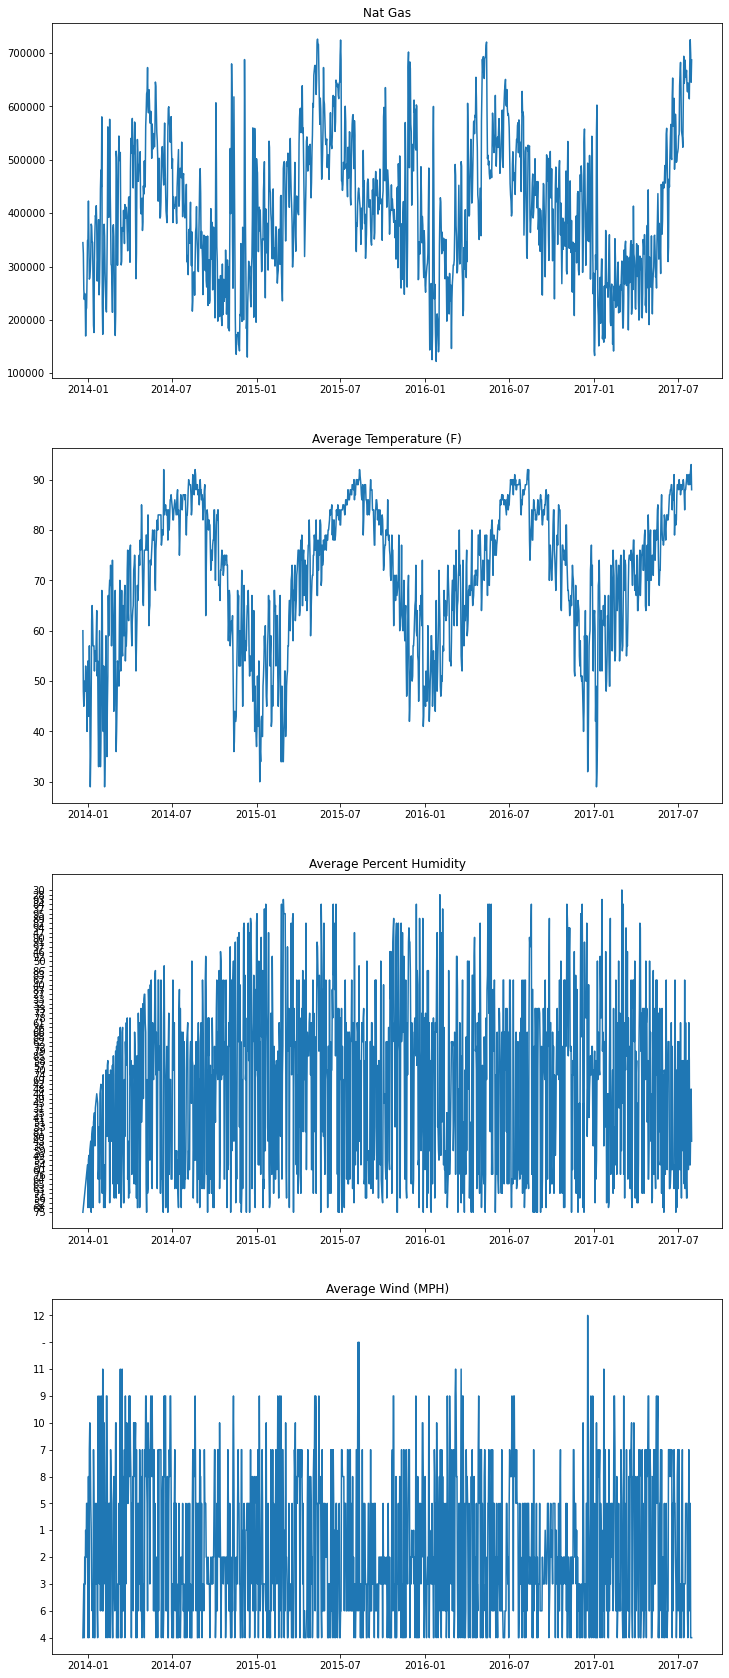

In [230]:
fig, axs = plt.subplots(4)
fig.set_figheight(30)
fig.set_figwidth(12)
axs[0].plot(df_full['NGas']);
axs[0].title.set_text('Nat Gas')
axs[1].plot(df_full['TempAvgF']);
axs[1].title.set_text('Average Temperature (F)')
axs[2].plot(df_full['HumidityAvgPercent']);
axs[2].title.set_text('Average Percent Humidity')
axs[3].plot(df_full['WindAvgMPH']);
axs[3].title.set_text('Average Wind (MPH)')


#### Problems were encountered attempting to relay correlation coefficents, with only temperature and natural gas being functionable. Therefore, multivariate modeling will proceed with these two features only.

In [235]:
df_full.corr()

,NGas,TempAvgF
NGas,1.00000,0.34687
TempAvgF,0.34687,1.00000


In [236]:
df_full=df_full.reset_index()[['date', 'NGas', 'TempAvgF']].rename({'date':'ds','NGas':'y','TempAvgF':'temp'},axis='columns')

In [237]:
df_full.head()

,ds,y,temp
0,2013-12-21,344801.99715,60
1,2013-12-22,324703.06293,48
2,2013-12-23,257270.86340,45
3,2013-12-24,238331.65052,46
4,2013-12-25,249436.38603,50


# 3. Model the data

#### Below, the data is split into a train and test. 15% of the data is set as the testing set.

In [238]:
train = df_final[(df_final['ds'] >= '2013-12-21') & (df_final['ds'] < '2017-01-01')]
test = df_final[(df_final['ds'] >= '2017-01-01')]

In [239]:
test.head()

,ds,y,temp
1107,2017-01-01,141613.098056,63
1108,2017-01-02,133299.837431,64
1109,2017-01-03,194640.611113,60
1110,2017-01-04,322016.536242,42
1111,2017-01-05,294446.048610,49


In [240]:
train

,ds,y,temp
0,2013-12-21,344801.997150,60
1,2013-12-22,324703.062930,48
2,2013-12-23,257270.863400,45
3,2013-12-24,238331.650520,46
4,2013-12-25,249436.386030,50
...,...,...,...
1102,2016-12-27,544135.696414,69
1103,2016-12-28,517874.066632,73
1104,2016-12-29,327643.698096,60
1105,2016-12-30,248546.588394,52


#### For our prophet model, we will set a confidence interval of 95% and include yearly seasonality.

In [242]:
m = Prophet(interval_width=0.95, yearly_seasonality=True)

In [243]:
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [244]:
m.params

{'k': array([[-0.03031728]]),
 'm': array([[0.54269643]]),
 'delta': array([[-4.14197031e-08,  3.27351377e-08, -6.04441124e-08,
          5.76532589e-08,  2.11859691e-02,  6.17735398e-02,
          8.46592322e-02,  8.27204841e-02,  3.44959136e-02,
          2.69747476e-08, -2.77729291e-08,  8.76239936e-09,
         -1.73454112e-04, -3.35177135e-02, -5.99193611e-02,
         -7.10016061e-02, -6.50965477e-02, -5.70900129e-02,
         -1.97463150e-02,  2.47492879e-08,  5.73068323e-08,
          1.77135585e-03,  2.01565615e-02,  1.09431265e-02,
          6.97980156e-04]]),
 'sigma_obs': array([[0.1228477]]),
 'beta': array([[ 0.05704178, -0.12009893, -0.06369326,  0.01855448,  0.00163284,
          0.00886334,  0.00033834,  0.00687895, -0.02045893, -0.00836598,
          0.00337814, -0.00162664,  0.00255622, -0.01476338, -0.00873464,
          0.0003521 ,  0.01106826, -0.00800721, -0.02092042, -0.01791078,
         -0.00160783,  0.00130925, -0.00634297,  0.00258908, -0.00087969,
         

#### Let's set future data to use for our predictions

In [249]:
future = m.make_future_dataframe(periods=638)
future.tail

<bound method NDFrame.tail of              ds
0    2013-12-21
1    2013-12-22
2    2013-12-23
3    2013-12-24
4    2013-12-25
...         ...
1740 2018-09-26
1741 2018-09-27
1742 2018-09-28
1743 2018-09-29
1744 2018-09-30

[1745 rows x 1 columns]>

In [250]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1740,2018-09-26,393814.439342,204708.270144,570687.935965
1741,2018-09-27,391971.841225,212606.798497,578498.825403
1742,2018-09-28,386568.051005,205564.228519,565998.254373
1743,2018-09-29,392765.003950,219495.188523,582343.411300
1744,2018-09-30,398278.745308,209035.219147,582944.435402


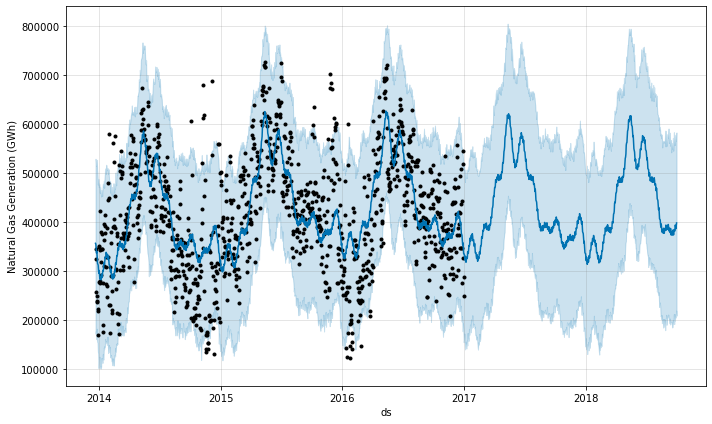

In [262]:
fig1 = m.plot(forecast, ylabel='Natural Gas Generation (GWh)')

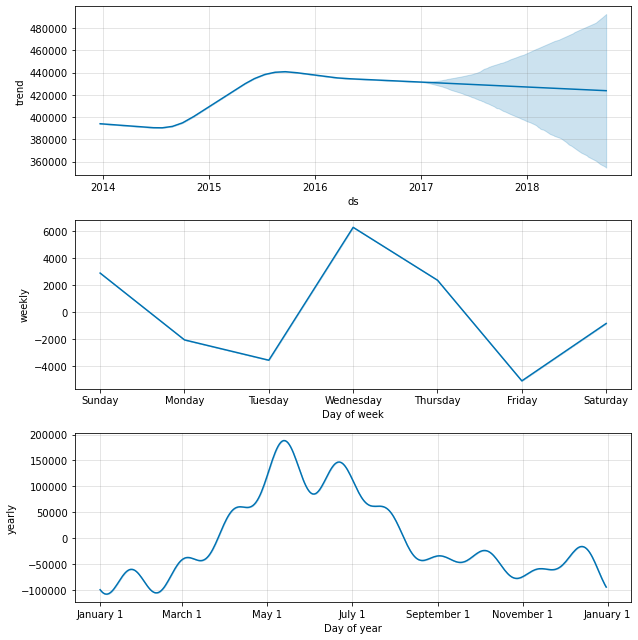

In [252]:
fig2 = m.plot_components(forecast)

# 4. Cross validate

### Cross Validation and Performance Metrics

#### We can measure the forecast error using Prophet's built-in cross validation functionality. This is accomplished by selecting cutoff points in the historical data and fitting the model using data only up to that cutoff point. This is applied to the model below.

In [253]:

cv_results = cross_validation(model = m, initial='1000 days', horizon='90 days')
df_p = performance_metrics(cv_results)
df_p

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-10-02 00:00:00 and 2016-10-02 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,9 days,6.739504e+09,82094.479700,70106.163975,0.215064,0.182954,1.000000
1,10 days,5.959007e+09,77194.604846,64860.147085,0.192648,0.162317,1.000000
2,11 days,6.311599e+09,79445.570574,70901.057543,0.206255,0.162317,1.000000
3,12 days,5.837376e+09,76402.720500,66365.031754,0.193261,0.127364,1.000000
4,13 days,5.686096e+09,75406.209455,64876.544941,0.187017,0.113580,1.000000
...,...,...,...,...,...,...,...
77,86 days,9.467958e+09,97303.430197,79818.356032,0.186278,0.168216,0.888889
78,87 days,1.250770e+10,111837.842808,94504.995897,0.210713,0.213857,0.888889
79,88 days,1.233366e+10,111057.003870,91098.961838,0.203347,0.213857,0.888889
80,89 days,1.280655e+10,113166.028184,95130.153658,0.224694,0.257885,0.888889


In [254]:
df_p['mape'].mean()

0.17077112808232006

#### Since MAPE was the error statistic of interest for our univariate models, above we have the mean MAPE across te different time horizons. This value of 17% is greater than the 14% achieved by the univariate model.

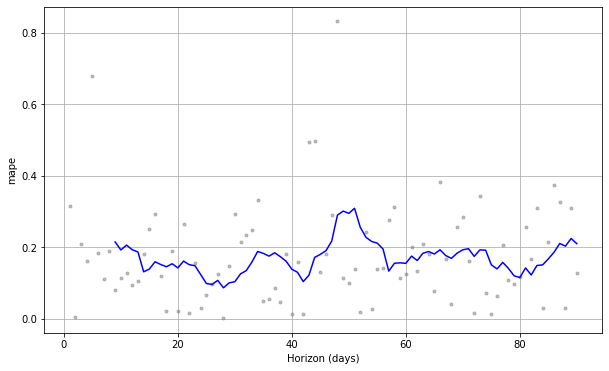

In [255]:
fig3 = plot_cross_validation_metric(cv_results, metric='mape')

#### Above, we can see where the MAPE is lowest for the different time horizons. This takes place at approximately 16-18 days.

# 5. Conclusions

#### Using correlation coefficents, we saw that there is a relationship between temperature and natural gas generation. We attempted to capture this relationship with a multivariate time series model using the Facebook Prophet package. The model performed relatively well, however did not perform better than the simple univariate model. Potential tweaking and feature engineering could potentially improve the performance and is worth investigating. Relative to the multivariate model incorporating monthly data, the model performed much better, which indicates the possibility that more data enhances our model's ability to forecast.